# Conveyance Curve Example

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# read the csv file
ws = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\references\river\conveyance\data'
conveyance_curve = os.path.join(ws, 'conveyance_curve_16.csv')
df = pd.read_csv(conveyance_curve)

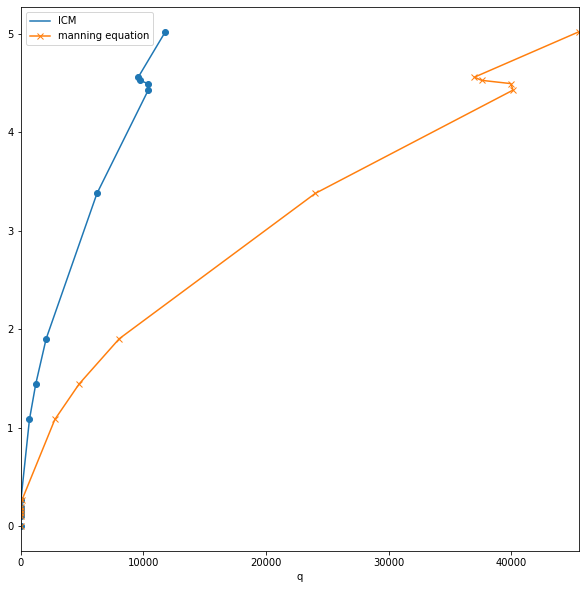

In [2]:
# perform the calculation

slope = 1 # seems ICM always uses 1

# calculate the hydraulic radus using the reported values in ICM
df['r'] = df['Area (ft2)']/df['Perimeter (ft)']

# using manning's equation to calculate the discharge
df['q'] = (1.49/0.013)*df['Area (ft2)']*(df['r']**(2/3))

# plot the results
ax = df.plot(x='no_panel', y='Depth (ft)', style='o-', label='ICM', figsize=(10,10))
df.plot(x='q', y='Depth (ft)', style='x-', ax=ax, label='manning equation')
plt.show()

In this case apparently, the slope term is not 1, and shown below, the ratio is around 3.86.

In [3]:
df['q']/df['no_panel']

0          NaN
1     3.869414
2     3.857853
3     3.857336
4     3.857031
5     3.856186
6     3.856649
7     3.856680
8     3.856735
9     3.856691
10    3.856733
11    3.856735
12    3.856758
13    3.856708
14    3.856725
dtype: float64

In [9]:
import numpy as np
f = os.path.join(ws, 'cross_section_16.csv')
df_xs = pd.read_csv(f)

In [16]:
def line_length(x, y, ignore=None):
    # ignore is used to filter out lines connecting two far apart dot.
    # since I am using regular spacing, if they distance between two dots is larger than the spacing, it means there is a disconnect.
    npts = len(x)
    # need to make sure it is a line with at least 2 points
    if npts < 2:
        return 0
    
    arc = np.sqrt((x[1] - x[0])**2 + (y[1] - y[0])**2)
    if ignore:
        if arc > ignore*1.1:
            arc = 0
            
    for k in range(1, npts):
        if ignore:
            if x[k] - x[k-1] > ignore*1.1:
                pass
            else:
                arc = arc + np.sqrt((x[k] - x[k-1])**2 + (y[k] - y[k-1])**2)
        else:
            arc = arc + np.sqrt((x[k] - x[k-1])**2 + (y[k] - y[k-1])**2)

    return arc

def get_area(xs_csv, level, level_fld='level', z_fld = 'z', offset_fld='offset'):
    df_xs = pd.read_csv(xs_csv)
    
    # interpolate profile using regular spacing so that I can calculate the area
    offset = np.linspace(min(df_xs[offset_fld].values), max(df_xs[offset_fld].values), 1000)
    z = np.interp(offset, df_xs[offset_fld], df_xs[z_fld])

    df2 = pd.DataFrame({'offset': offset, 'z': z})
    df2[level_fld] = [level]*len(offset)
    # get the dx for the x axis
    dx = df2[offset_fld].diff().values[-1]
    # find the area below the water level
    area = df2.loc[df2[level_fld] >= df2[z_fld]]
    # get the area under level line
    a1 = np.trapz(area[level_fld], x=None, dx=dx, axis=-1)
    # get the area under the cross section
    a2 = np.trapz(area[z_fld], x=None, dx=dx, axis=-1)
    a3 = a1 - a2
    l = line_length(area[offset_fld].values, area[z_fld].values, dx)
    
    
    
    ax = df_xs.plot(x=offset_fld, y=z_fld, linewidth=3, alpha=0.5, figsize=(10,4), label='bed elevation')
    area.plot(x=offset_fld, y=z_fld,  style='x-',ax=ax, label='intepolated z')
    area.plot(x=offset_fld, y=level_fld, ax=ax)
    plt.title(level)
    return a3, l

,Depth (ft),Area (ft2),python_area,Perimeter (ft),python_perimeter
0,0.000,0.000,0.000000,1.618,1.631427
1,0.098,0.298,0.296958,10.922,4.493346
2,0.131,0.725,0.726082,18.335,18.363346
3,0.164,1.336,1.339447,18.928,18.888694
4,0.197,1.983,1.993317,22.214,22.105834
5,0.262,3.565,3.561866,27.716,27.679801
6,1.083,27.320,27.342426,32.446,32.411388
7,1.444,39.039,39.067538,35.434,35.426891
8,1.903,55.227,55.246797,38.589,38.536492
9,3.379,112.282,112.286779,44.072,42.323087


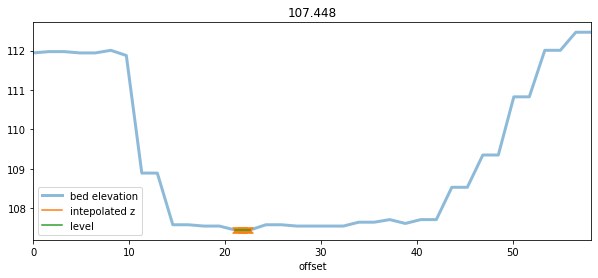

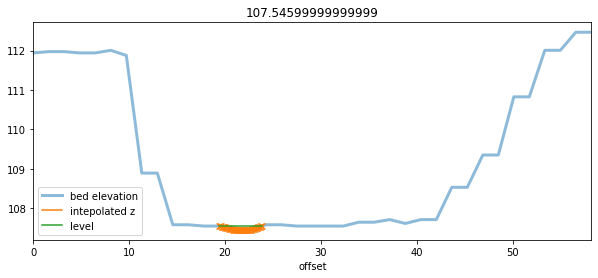

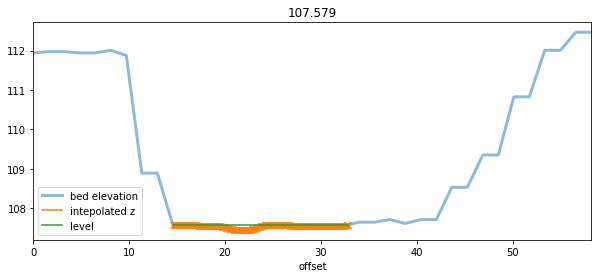

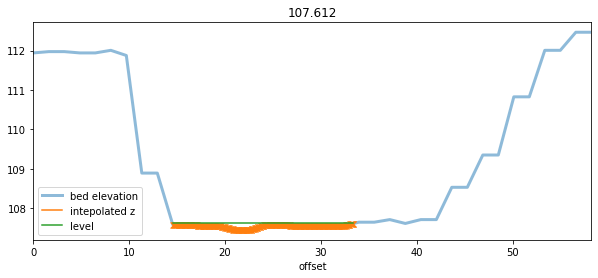

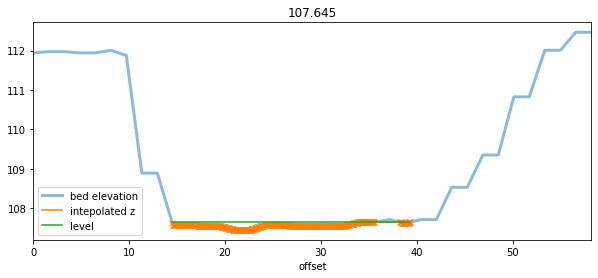

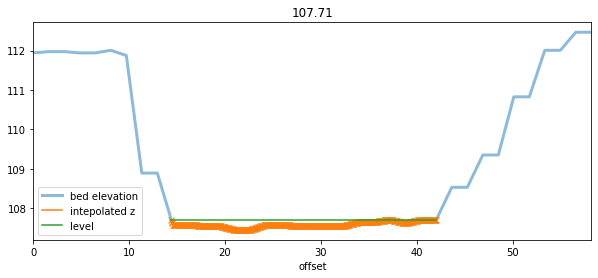

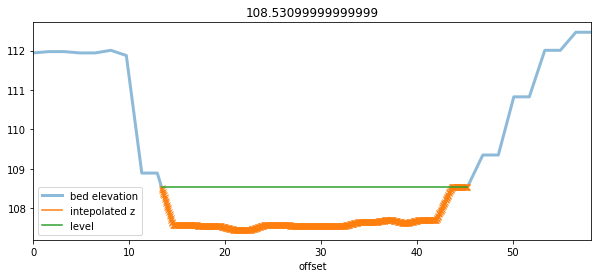

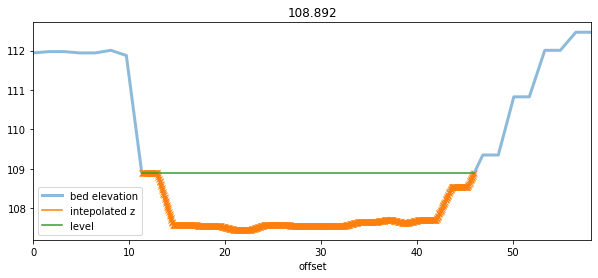

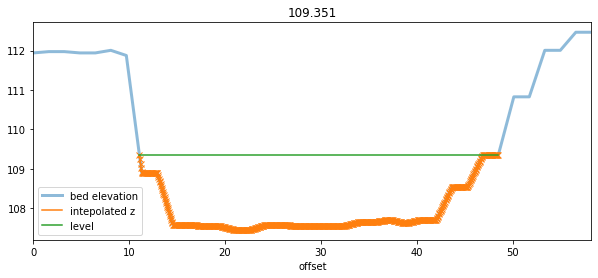

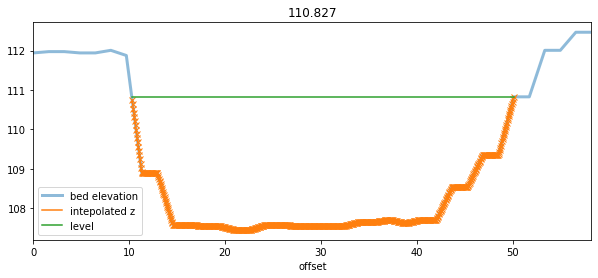

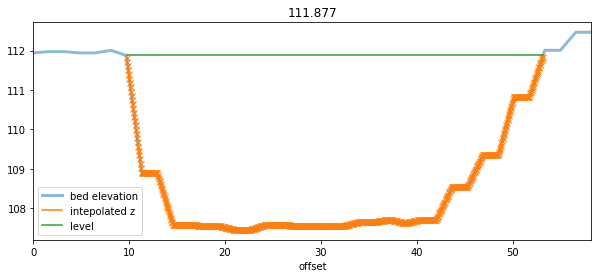

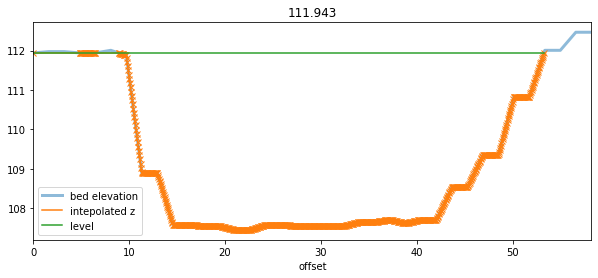

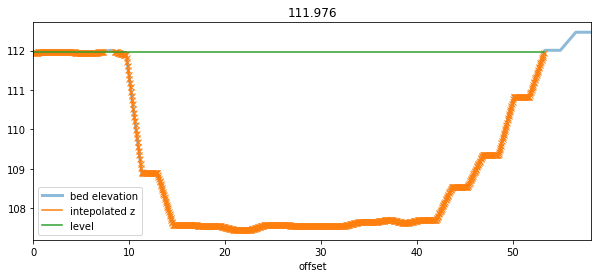

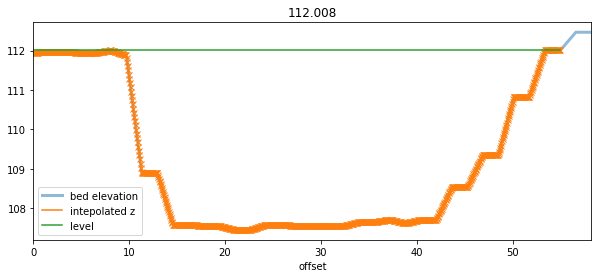

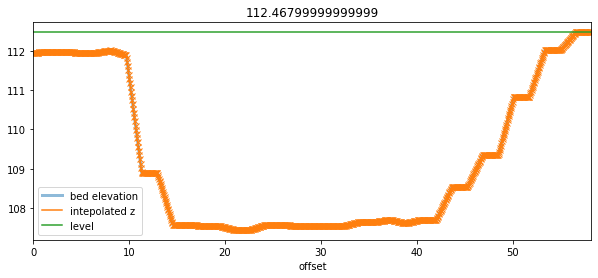

In [17]:
df['python_area'] = 0
df['python_perimeter'] = 0
invert = 107.448
for idx, r in df.iterrows():
    level = r['Depth (ft)']
    icm_area = r['Area (ft2)']
    
    a, l = get_area(xs_csv=f, level=level+invert, level_fld='level', z_fld = 'z', offset_fld='offset')
    df.loc[idx, 'python_area'] = a
    df.loc[idx, 'python_perimeter'] = l
    
    
    
df.loc[:, ['Depth (ft)', 'Area (ft2)', 'python_area', 'Perimeter (ft)', 'python_perimeter']]
    

In [54]:
import pandas as pd
import csv
import plotly.graph_objects as go


def plot_xs(conveyance_df, xs_df, invert, level_fld='level', z_fld = 'z', offset_fld='offset'):
    df_xs = xs_df.copy()
    fig = go.Figure()
#     ax = df_xs.plot(x=offset_fld, y=z_fld, linewidth=3, alpha=0.5, color='grey', figsize=(20,10), label='bed elevation')
    fig.add_trace(go.Scatter(
        x = df_xs[offset_fld],
        y = df_xs[z_fld],
        name = 'bed elevation',
        mode='lines+markers',
        line=dict(color='grey')
    ))
    for idx, r in conveyance_df.iterrows():
        level = r['Depth (ft)'] + invert
        icm_area = r['Area (ft2)']
        df_xs['level'] = level
        fig.add_trace(go.Scatter(
        x = df_xs[offset_fld],
        y = df_xs['level'],
        name = 'Depth=%s' % r['Depth (ft)'],
        line=dict(color='blue', dash='dot')
    ))
#         df_xs.plot(x=offset_fld, y='level', style='--', color='blue', alpha=0.2, label='Depth=%s' % r['Depth (ft)'], ax=ax)
    return fig
        
        

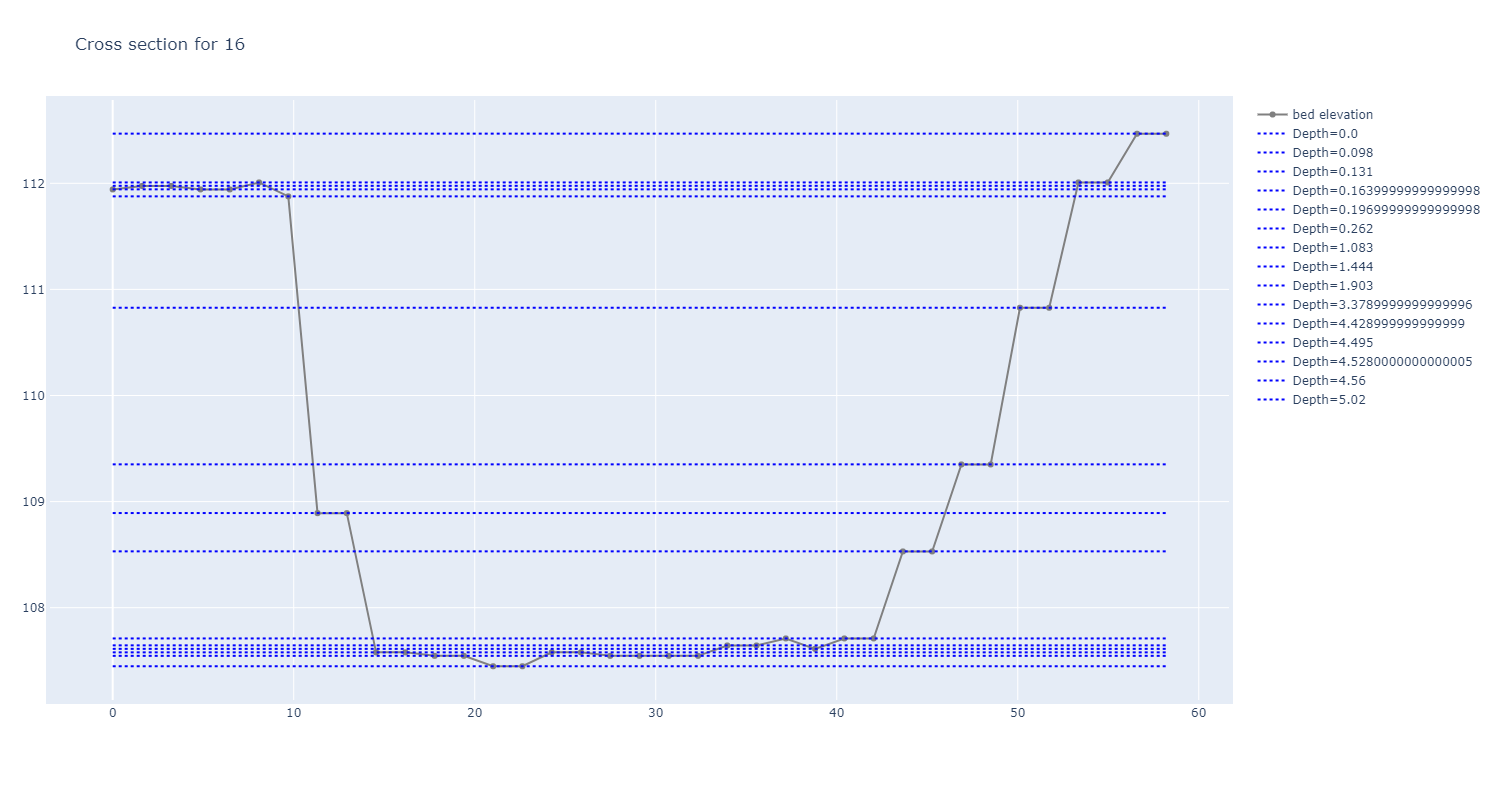

In [58]:
invert = 107.448
fig = plot_xs(conveyance_df=df, xs_df=df_xs, invert=invert, level_fld='level', z_fld = 'z', offset_fld='offset')

fig.update_layout(
    title='Cross section for 16',
    autosize=True,
    width=1200,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="White",
)

In [92]:
import pandas as pd
import csv
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def plot_xs(conveyance_df, xs_df, invert, level_fld='level', z_fld = 'z', offset_fld='offset'):
    df_xs = xs_df.copy()
    df_cv = conveyance_df.copy()
    df_cv['z'] = df_cv['Depth (ft)'] + invert
    fig = make_subplots(rows=1, cols=2, 
                        shared_yaxes=True, 
                        vertical_spacing=0.01
                       )
#     ax = df_xs.plot(x=offset_fld, y=z_fld, linewidth=3, alpha=0.5, color='grey', figsize=(20,10), label='bed elevation')
    fig.add_trace(go.Scatter(
        x = df_xs[offset_fld],
        y = df_xs[z_fld],
        name = 'bed elevation',
        mode='lines+markers',
        line=dict(color='grey')
    ), row=1, col=1 )
    
    hovertext = []
    for idx, r in df_cv.iterrows():
        hovertext.append('q=%.2f Area=%.2f Perimeter=%.2f' % (r['no_panel'], r['Area (ft2)'], r['Perimeter (ft)'])) 
    fig.add_trace(go.Scatter(
        x = df_cv['no_panel'],
        y = df_cv['z'],
        name = 'conveyance curve',
        mode='lines+markers',
        hovertext = hovertext,
        line=dict(color='blue')
    ), row=1, col=2 )
        
    for idx, r in conveyance_df.iterrows():
        level = r['Depth (ft)'] + invert
        icm_area = r['Area (ft2)']
        df_xs['level'] = level
        fig.add_trace(go.Scatter(
        x = df_xs[offset_fld],
        y = df_xs['level'],
        name = 'Depth=%s' % r['Depth (ft)'],
        line=dict(color='blue', dash='dot')
    ), row=1, col=1)
#         df_xs.plot(x=offset_fld, y='level', style='--', color='blue', alpha=0.2, label='Depth=%s' % r['Depth (ft)'], ax=ax)
    return fig
        
        

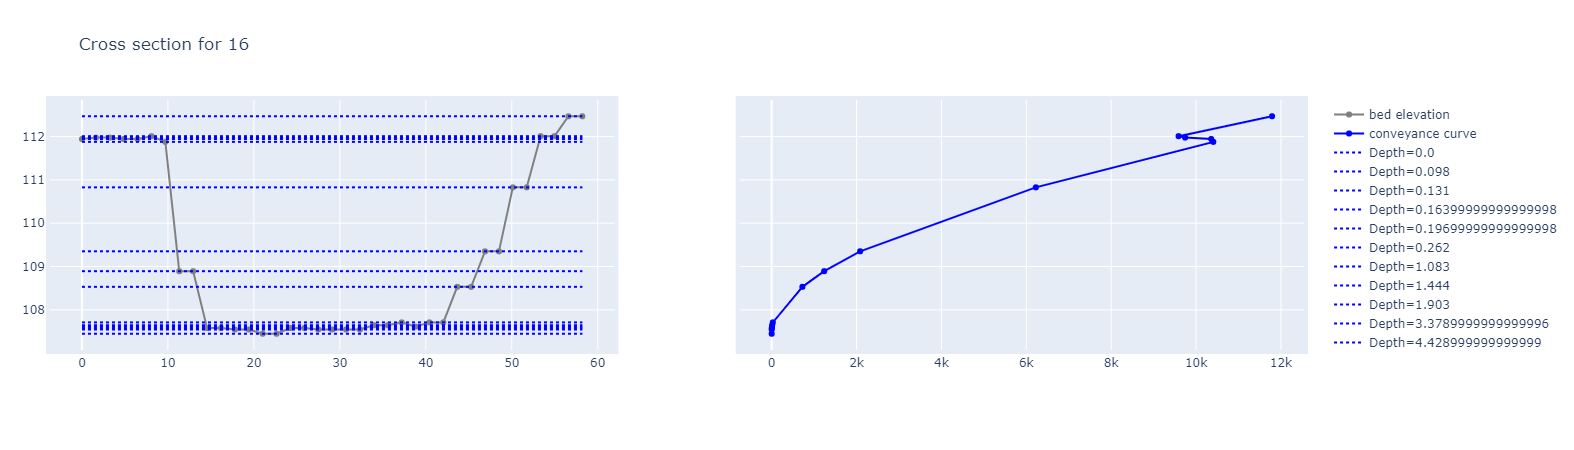

In [93]:
invert = 107.448
fig = plot_xs(conveyance_df=df, xs_df=df_xs, invert=invert, level_fld='level', z_fld = 'z', offset_fld='offset')

fig.update_layout(
    title='Cross section for 16',
    autosize=True,
#     width=2400,
#     height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="White",
)